## Implementation of VGGFace in Tensorflow, Keras

### Imports

In [1]:
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Activation, AveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.preprocessing import image

K = tf.keras.backend

### VGG16 backbone

In [59]:
def VGGFace(include_top=True, weights='vggface', input_shape=None, pooling=None, classes=2622):
    if input_shape is not None:
        input_img = Input(shape=input_shape)
    else:
        print("Please provide input shape.")
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(
        input_img)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(
        x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2')(
        x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(
        x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(
        x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3')(
        x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(
        x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(
        x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3')(
        x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1')(
        x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2')(
        x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3')(
        x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool5')(x)
    
    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, name='fc6')(x)
        x = Activation('relu', name='fc6/relu')(x)
        x = Dense(4096, name='fc7')(x)
        x = Activation('relu', name='fc7/relu')(x)
        x = Dense(classes, name='fc8')(x)
        x = Activation('softmax', name='fc8/softmax')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        if pooling == 'max':
            x = GlobalMaxPooling2D()(x)
            
    model = Model(input_img, x, name='vggface_vgg16')
    if weights == 'vggface':
        if include_top:
            weights_path = "./weights/vggface_tf_vgg16.h5"
        else:
            pass
        
        model.load_weights(weights_path, by_name=True)
        
    return model


In [60]:
model = VGGFace(include_top=True, weights='vggface', input_shape=(224, 224, 3), pooling='avg', classes=2622)

In [61]:
model.summary()

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)     

In [62]:
vggface = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [63]:
vggface.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

### Face Verification

In [2]:
# initializing th classifiers
cascPath=os.path.dirname(cv2.__file__)+"/data/haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascPath)
def detect_face(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)
    faces = faceCascade.detectMultiScale(img, 1.3, 5)
    
    if len(faces) > 0:
        x,y,w,h = faces[0]
        
        margin = 0
        x_margin = w * margin / 100
        y_margin = h * margin / 100
        
        if y - y_margin > 0 and y+h+y_margin < img.shape[1] and x-x_margin > 0 and x+w+x_margin < img.shape[0]:
            detected_face = img[int(y-y_margin):int(y+h+y_margin), int(x-x_margin):int(x+w+x_margin)]
        else:
            detected_face = img[int(y):int(y+h), int(x):int(x+w)]
        
        detected_face = cv2.resize(detected_face, target_size)
        
        img_pixels = image.img_to_array(detected_face)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        
        #normalize in [0, 1]
        img_pixels /= 255 
        
        return img_pixels
    else:
        raise ValueError("Face could not be detected in ", img_path,". Please confirm that the picture is a face photo.")

### Vector Similarity

In [15]:
def l2_normalization(x):
    return x / np.sqrt(np.sum(np.multiply(x, x)))

def findCosineDistance(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))
 
def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance


### Verification Function

In [4]:
epsilon = 0.4 # cosine distance

In [5]:
dataset = [
    ['tests/fine_tune/img1.jpg', 'tests/fine_tune/img2.jpg']
    , ['tests/fine_tune/img3.jpg', 'tests/fine_tune/img4.jpg']
    , ['tests/fine_tune/img8.jpg', 'tests/fine_tune/img9.jpg']
    , ['tests/fine_tune/img13.jpg', 'tests/fine_tune/img14.jpg']
    , ['tests/fine_tune/img16.jpg', 'tests/fine_tune/img17.jpg']
    , ['tests/fine_tune/img18.jpg', 'tests/fine_tune/img19.jpg']
    , ['tests/fine_tune/img35.jpg', 'tests/fine_tune/img36.jpg']
        
    , ['tests/fine_tune/img1.jpg', 'tests/fine_tune/img3.jpg']
    , ['tests/fine_tune/img1.jpg', 'tests/fine_tune/img4.jpg']
    , ['tests/fine_tune/img2.jpg', 'tests/fine_tune/img3.jpg']
    , ['tests/fine_tune/img2.jpg', 'tests/fine_tune/img4.jpg']
    , ['tests/fine_tune/img1.jpg', 'tests/fine_tune/img5.jpg']
    , ['tests/fine_tune/img2.jpg', 'tests/fine_tune/img5.jpg']
]

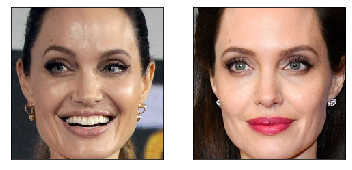

Verified!!!
They are same person.
Cosine Distance:  0.2987210154533386


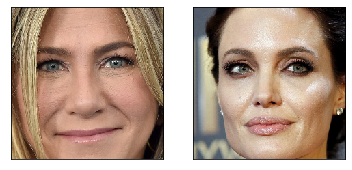

Unverified!!
They are different person
Cosine Distance:  0.6668162941932678


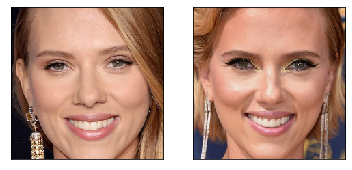

Verified!!!
They are same person.
Cosine Distance:  0.28084880113601685


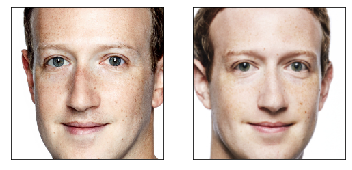

Verified!!!
They are same person.
Cosine Distance:  0.08368074893951416


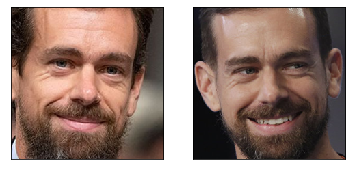

Verified!!!
They are same person.
Cosine Distance:  0.248363196849823


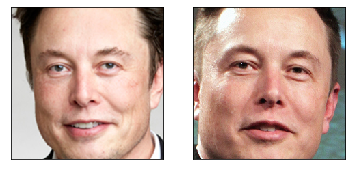

Verified!!!
They are same person.
Cosine Distance:  0.09661555290222168


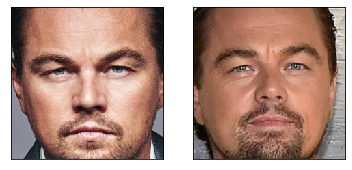

Verified!!!
They are same person.
Cosine Distance:  0.19143390655517578


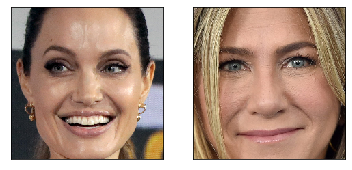

Unverified!!
They are different person
Cosine Distance:  0.6413719058036804


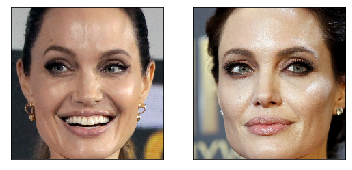

Verified!!!
They are same person.
Cosine Distance:  0.2541481852531433


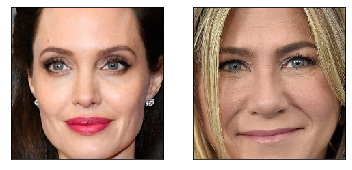

Unverified!!
They are different person
Cosine Distance:  0.6957427263259888


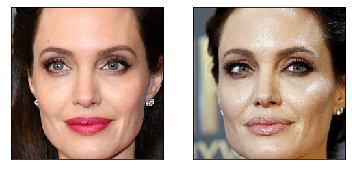

Verified!!!
They are same person.
Cosine Distance:  0.12719398736953735


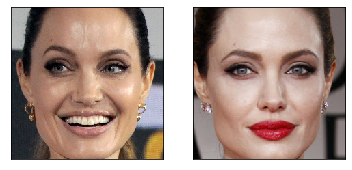

Verified!!!
They are same person.
Cosine Distance:  0.3647960424423218


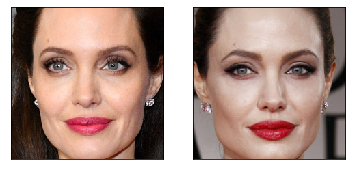

Verified!!!
They are same person.
Cosine Distance:  0.2129230499267578


In [68]:
for i in dataset:
    img1_path = i[0]
    img2_path = i[1]
    
    face1 = detect_face(img1_path)
    face2 = detect_face(img2_path)
    
    img1_representation = vggface.predict(face1)[0,:]
    img2_representation = vggface.predict(face2)[0,:]
    
    cosine_distance = findCosineDistance(img1_representation, img2_representation)
    euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)
    
    
    fig = plt.figure()
    fig.add_subplot(1,2, 1)
    plt.imshow(face1[0][:, :, ::-1])
    plt.xticks([]); plt.yticks([])
    fig.add_subplot(1,2, 2)
    plt.imshow(face2[0][:, :, ::-1])
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    
    
    if(cosine_distance < epsilon):
        print("Verified!!!")
        print("They are same person.")
        print("Cosine Distance: ", cosine_distance)
        
    else:
        print("Unverified!!")
        print("They are different person")
        print("Cosine Distance: ", cosine_distance )

### ResNet50 Backbone

#### Identity Block

In [6]:
def identity_block(input_tensor, kernel_size, filters, stage, block, bias=False):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv1_reduce_name = 'conv' + str(stage) + "_" + str(block) + "_1x1_reduce"
    conv1_increase_name = 'conv' + str(stage) + "_" + str(
        block) + "_1x1_increase"
    conv3_name = 'conv' + str(stage) + "_" + str(block) + "_3x3"

    x = Conv2D(filters1, (1, 1), use_bias=bias, name=conv1_reduce_name)(
        input_tensor)
    x = BatchNormalization(axis=bn_axis, name=conv1_reduce_name + "/bn")(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, use_bias=bias,
               padding='same', name=conv3_name)(x)
    x = BatchNormalization(axis=bn_axis, name=conv3_name + "/bn")(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), use_bias=bias, name=conv1_increase_name)(x)
    x = BatchNormalization(axis=bn_axis, name=conv1_increase_name + "/bn")(x)

    x = tf.keras.layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x

#### Convolution Block

In [7]:
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2), bias=False):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv1_reduce_name = 'conv' + str(stage) + "_" + str(block) + "_1x1_reduce"
    conv1_increase_name = 'conv' + str(stage) + "_" + str(
        block) + "_1x1_increase"
    conv1_proj_name = 'conv' + str(stage) + "_" + str(block) + "_1x1_proj"
    conv3_name = 'conv' + str(stage) + "_" + str(block) + "_3x3"

    x = Conv2D(filters1, (1, 1), strides=strides, use_bias=bias,
               name=conv1_reduce_name)(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=conv1_reduce_name + "/bn")(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', use_bias=bias,
               name=conv3_name)(x)
    x = BatchNormalization(axis=bn_axis, name=conv3_name + "/bn")(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv1_increase_name, use_bias=bias)(x)
    x = BatchNormalization(axis=bn_axis, name=conv1_increase_name + "/bn")(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides, use_bias=bias,
                      name=conv1_proj_name)(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=conv1_proj_name + "/bn")(shortcut)

    x = tf.keras.layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [8]:
def ResNet50(include_top=True, weights='vggface', input_shape=None, pooling=None, classes=8631):
    if input_shape is not None:
        input_img = Input(shape=input_shape)
    else:
        print("Please provide input shape.")

    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = Conv2D(64, (7, 7), use_bias=False, strides=(2, 2), padding='same', name='conv1/7x7_s2')(input_img)
    x = BatchNormalization(axis=bn_axis, name='conv1/7x7_s2/bn')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block=1, strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block=2)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block=3)

    x = conv_block(x, 3, [128, 128, 512], stage=3, block=1)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=2)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=3)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=4)

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block=1)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=2)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=3)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=4)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=5)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=6)

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block=1)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block=2)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block=3)

    x = AveragePooling2D((7, 7), name='avg_pool')(x)

    if include_top:
        x = Flatten()(x)
        x = Dense(classes, name='classifier')(x)
        x = Activation('softmax')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)
            
    model = Model(input_img, x, name='vggface_ResNet50')
    if weights == 'vggface':
        if include_top:
            weights_path = "./weights/vggface_tf_resnet50.h5"
        else:
            pass
        
        model.load_weights(weights_path, by_name=True)
        
    return model

    

In [9]:
model = ResNet50(include_top=True, weights='vggface', input_shape=(224, 224, 3), pooling='avg', classes=8631)

In [10]:
vggface = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [11]:
vggface.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv4_4_3x3/bn (BatchNormalizat (None, 14, 14, 256)  1024        conv4_4_3x3[0][0]                
__________________________________________________________________________________________________
activation_32 (Activation)      (None, 14, 14, 256)  0           conv4_4_3x3/bn[0][0]             
__________________________________________________________________________________________________
conv4_4_1x1_increase (Conv2D)   (None, 14, 14, 1024) 262144      activation_32[0][0]              
__________________________________________________________________________________________________
conv4_4_1x1_increase/bn (BatchN (None, 14, 14, 1024) 4096        conv4_4_1x1_increase[0][0]       
__________________________________________________________________________________________________
add_10 (Add)                    (None, 14, 14, 1024) 0           conv4_4_1x1_increase/bn[0][0]    
          

In [26]:
def CosineSimilarity(u, v):
    # compute the dot product between the word
    dot = u @ v
    # Compute the L2 norm of u
    norm_u  = np.linalg.norm(u)
    # Compute the L2 norm of v
    norm_v = np.linalg.norm(v)
    # Compute the cosine similarity by formula
    cosine_similarity = dot / (norm_u * norm_v)
    
    return cosine_similarity
    

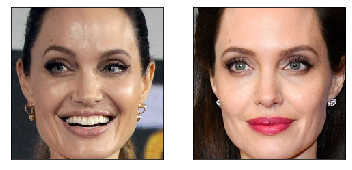

Verified!!!
They are same person.
Cosine Similarity:  0.9999347


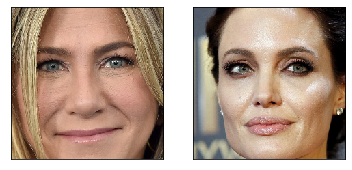

Unverified!!
They are different person
Cosine Similarity:  0.9998677


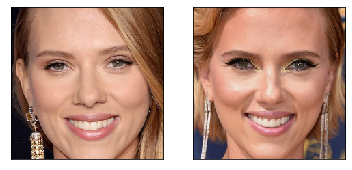

Verified!!!
They are same person.
Cosine Similarity:  0.9999784


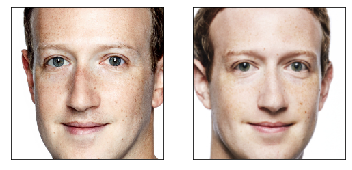

Unverified!!
They are different person
Cosine Similarity:  0.99983805


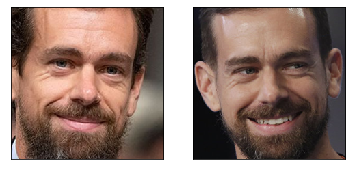

Verified!!!
They are same person.
Cosine Similarity:  0.99995923


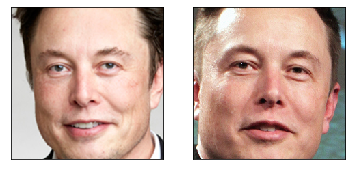

Verified!!!
They are same person.
Cosine Similarity:  0.9998925


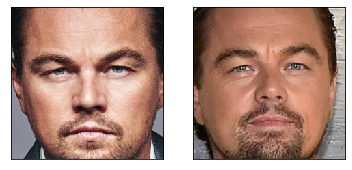

Unverified!!
They are different person
Cosine Similarity:  0.9998087


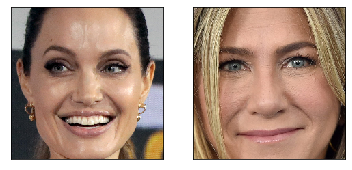

Verified!!!
They are same person.
Cosine Similarity:  0.9999541


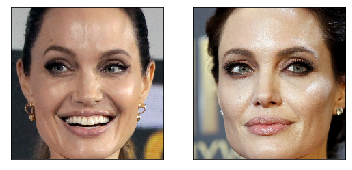

Unverified!!
They are different person
Cosine Similarity:  0.9998566


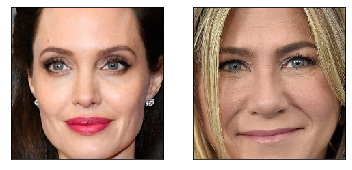

Verified!!!
They are same person.
Cosine Similarity:  0.9999499


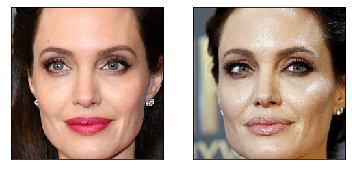

Verified!!!
They are same person.
Cosine Similarity:  0.99991816


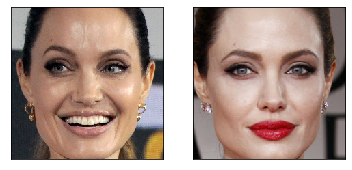

Verified!!!
They are same person.
Cosine Similarity:  0.9999032


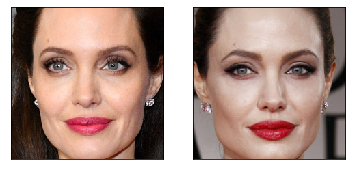

Verified!!!
They are same person.
Cosine Similarity:  0.9999694


In [30]:
for i in dataset:
    img1_path = i[0]
    img2_path = i[1]
    
    face1 = detect_face(img1_path)
    face2 = detect_face(img2_path)
    
    img1_representation = vggface.predict(face1)[0,:]
    img2_representation = vggface.predict(face2)[0,:]
    
    cosine_similarity = CosineSimilarity(img1_representation, img2_representation)
    
    fig = plt.figure()
    fig.add_subplot(1,2, 1)
    plt.imshow(face1[0][:, :, ::-1])
    plt.xticks([]); plt.yticks([])
    fig.add_subplot(1,2, 2)
    plt.imshow(face2[0][:, :, ::-1])
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    
    
    if(cosine_similarity > 0.9998677):
        print("Verified!!!")
        print("They are same person.")
        print("Cosine Similarity: ",  cosine_similarity)
        
    else:
        print("Unverified!!")
        print("They are different person")
        print("Cosine Similarity: ",  cosine_similarity)